In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')
tags_df = pd.read_csv('tags.csv')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity



In [150]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [151]:
movies_df.shape

(34208, 3)

In [152]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496


In [153]:
ratings_df.shape

(22884377, 4)

In [154]:
tags_df.head()

,userId,movieId,tag,timestamp
0,19,2324,bittersweet,1428651158
1,19,2324,holocaust,1428651112
2,19,2324,World War II,1428651118
3,23,7075,hilarious,1378675786
4,23,7075,Underrated,1378675786


In [155]:
tags_df.shape

(586994, 4)

In [156]:
movies_df.info()
ratings_df.info()
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34208 entries, 0 to 34207
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  34208 non-null  int64 
 1   title    34208 non-null  object
 2   genres   34208 non-null  object
dtypes: int64(1), object(2)
memory usage: 801.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22884377 entries, 0 to 22884376
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 698.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586994 entries, 0 to 586993
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     586994 non-null  int64 
 1   movieId    586994 non-null  int64 
 2   tag        586978 non-null  object
 3   timestamp  586994 non-null  in

In [157]:
merged_df = pd.merge(tags_df, ratings_df, on=['movieId', 'userId'], how='left')

merged_df.head()

,userId,movieId,tag,timestamp_x,rating,timestamp_y
0,19,2324,bittersweet,1428651158,NaN,NaN
1,19,2324,holocaust,1428651112,NaN,NaN
2,19,2324,World War II,1428651118,NaN,NaN
3,23,7075,hilarious,1378675786,5.0,1.378676e+09
4,23,7075,Underrated,1378675786,5.0,1.378676e+09


In [158]:
combined_df = pd.merge(merged_df, movies_df, on='movieId', how='left')
combined_df.head()

,userId,movieId,tag,timestamp_x,rating,timestamp_y,title,genres
0,19,2324,bittersweet,1428651158,NaN,NaN,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War
1,19,2324,holocaust,1428651112,NaN,NaN,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War
2,19,2324,World War II,1428651118,NaN,NaN,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War
3,23,7075,hilarious,1378675786,5.0,1.378676e+09,"Court Jester, The (1956)",Adventure|Comedy|Musical
4,23,7075,Underrated,1378675786,5.0,1.378676e+09,"Court Jester, The (1956)",Adventure|Comedy|Musical


In [159]:
# Rename 'timestamp_x' to 'tag_timestamp'
combined_df.rename(columns={'timestamp_x': 'tag_timestamp'}, inplace=True)

# Rename 'timestamp_y' to 'rating_timestamp'
combined_df.rename(columns={'timestamp_y': 'rating_timestamp'}, inplace=True)

# Convert 'tag_timestamp' columns to datetime format
combined_df['tag_timestamp'] = pd.to_datetime(combined_df['tag_timestamp'], unit='s')

# Convert 'rating_timestamp' columns to datetime format
combined_df['rating_timestamp'] = pd.to_datetime(combined_df['rating_timestamp'], unit='s')

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586994 entries, 0 to 586993
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   userId            586994 non-null  int64         
 1   movieId           586994 non-null  int64         
 2   tag               586978 non-null  object        
 3   tag_timestamp     586994 non-null  datetime64[ns]
 4   rating            498936 non-null  float64       
 5   rating_timestamp  498936 non-null  datetime64[ns]
 6   title             586994 non-null  object        
 7   genres            586994 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 35.8+ MB


In [160]:
# Drop duplicate entries
combined_df.drop_duplicates(inplace=True)

combined_df.isnull().sum()

userId                  0
movieId                 0
tag                    16
tag_timestamp           0
rating              88058
rating_timestamp    88058
title                   0
genres                  0
dtype: int64

In [161]:
#we have some messing values in two columns rating, rating_timestamp so we will calculate the outliers 
#calculate the IQR and upper/lower bounds for 'rating' column
Q1 = combined_df['rating'].quantile(.25)
Q3 = combined_df['rating'].quantile(.75)
IQR = Q3 - Q1 
IQR

1.0

In [162]:
RV = Q1 - (1.5*IQR)
LV = Q3 + (1.5 *IQR) 
RV,LV

(2.0, 6.0)

In [163]:
combined_df['rating'].describe()

count    498936.000000
mean          3.819012
std           1.023552
min           0.500000
25%           3.500000
50%           4.000000
75%           4.500000
max           5.000000
Name: rating, dtype: float64

In [164]:
# Fill NaN values in 'title' and 'tag'
combined_df['title'] = combined_df['title'].fillna('')
combined_df['tag'] = combined_df['tag'].fillna('')

# Combine 'title' and 'tag' into a new column 'combined'
combined_df['combined'] = combined_df['title'] + ' ' + combined_df['tag']

# Display the first few rows of the dataset with the combined column
print(combined_df[['title', 'tag', 'combined']].head())

                                        title           tag  \
0  Life Is Beautiful (La Vita è bella) (1997)   bittersweet   
1  Life Is Beautiful (La Vita è bella) (1997)     holocaust   
2  Life Is Beautiful (La Vita è bella) (1997)  World War II   
3                    Court Jester, The (1956)     hilarious   
4                    Court Jester, The (1956)    Underrated   

                                            combined  
0  Life Is Beautiful (La Vita è bella) (1997) bit...  
1  Life Is Beautiful (La Vita è bella) (1997) hol...  
2  Life Is Beautiful (La Vita è bella) (1997) Wor...  
3                 Court Jester, The (1956) hilarious  
4                Court Jester, The (1956) Underrated  


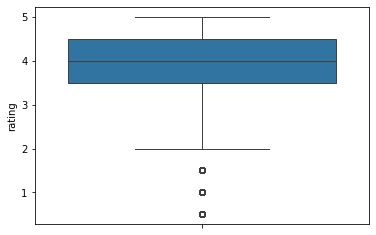

In [165]:
#we will boxplot the rating data to see outliers 
sns.boxplot(combined_df['rating'])
plt.show()

In [166]:
#we will see the number of values which are greater than 5 in the below cells and value less than 1.5
df1 = combined_df['rating']>5
df1.value_counts()

rating
False    586994
Name: count, dtype: int64

In [167]:
df2 = combined_df['rating']<1.5
df2.value_counts()

rating
False    571667
True      15327
Name: count, dtype: int64

In [168]:
#As there are outliers present here we will replace the null values with median
#first I have another way to calculate outliers to make sure 
outliers = combined_df[(combined_df['rating']<RV)|(combined_df['rating']>LV)]
outliers

,userId,movieId,tag,tag_timestamp,rating,rating_timestamp,title,genres,combined
8,157,7142,bad script,2013-03-04 04:33:47,1.0,2013-03-04 04:10:06,Honey (2003),Drama|Romance,Honey (2003) bad script
9,157,7142,no plot,2013-03-04 04:33:32,1.0,2013-03-04 04:10:06,Honey (2003),Drama|Romance,Honey (2003) no plot
52,178,2384,steak,2006-02-17 22:46:07,1.5,2006-02-17 22:46:01,Babe: Pig in the City (1998),Adventure|Children|Drama,Babe: Pig in the City (1998) steak
181,320,260,schematic adventure,2015-07-26 19:47:56,0.5,2015-07-26 20:01:06,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,Star Wars: Episode IV - A New Hope (1977) sche...
182,320,260,stereotyped heroes,2015-07-26 19:48:06,0.5,2015-07-26 20:01:06,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,Star Wars: Episode IV - A New Hope (1977) ster...
...,...,...,...,...,...,...,...,...,...
586806,247700,69372,not funny,2011-01-24 14:40:04,1.0,2011-01-24 05:43:14,Big Man Japan (Dai-Nihonjin) (2007),Comedy|Sci-Fi,Big Man Japan (Dai-Nihonjin) (2007) not funny
586807,247700,69372,not worth your time,2011-01-24 05:45:00,1.0,2011-01-24 05:43:14,Big Man Japan (Dai-Nihonjin) (2007),Comedy|Sci-Fi,Big Man Japan (Dai-Nihonjin) (2007) not worth ...
586905,247700,79357,chaos,2010-12-30 05:42:44,1.5,2010-12-30 05:42:24,Mr. Nobody (2009),Drama|Fantasy|Romance|Sci-Fi,Mr. Nobody (2009) chaos
586906,247700,79357,style over substance,2010-12-30 05:42:39,1.5,2010-12-30 05:42:24,Mr. Nobody (2009),Drama|Fantasy|Romance|Sci-Fi,Mr. Nobody (2009) style over substance


In [169]:
combined_df['rating'] = combined_df['rating'].replace(np.nan, combined_df['rating'].median())

In [170]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586994 entries, 0 to 586993
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   userId            586994 non-null  int64         
 1   movieId           586994 non-null  int64         
 2   tag               586994 non-null  object        
 3   tag_timestamp     586994 non-null  datetime64[ns]
 4   rating            586994 non-null  float64       
 5   rating_timestamp  498936 non-null  datetime64[ns]
 6   title             586994 non-null  object        
 7   genres            586994 non-null  object        
 8   combined          586994 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 40.3+ MB


In [171]:
# Now we have to deal with the rating_timestamp so we will do time-based interpolation 
# Sort the DataFrame by timestamp before interpolating
combined_df.sort_values(by='rating_timestamp', inplace=True)

# Interpolate missing timestamps
combined_df['rating_timestamp'].interpolate(method='pad', inplace=True)

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 586994 entries, 490733 to 586990
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   userId            586994 non-null  int64         
 1   movieId           586994 non-null  int64         
 2   tag               586994 non-null  object        
 3   tag_timestamp     586994 non-null  datetime64[ns]
 4   rating            586994 non-null  float64       
 5   rating_timestamp  586994 non-null  datetime64[ns]
 6   title             586994 non-null  object        
 7   genres            586994 non-null  object        
 8   combined          586994 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 44.8+ MB


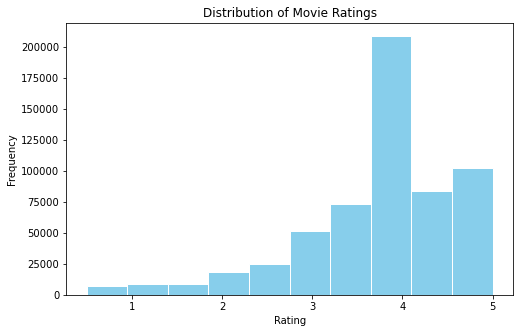

In [172]:
# NOW ANALYSIS 
# First, let's start with "Distribution of Ratings". Let's plot the distribution of movie ratings to understand the distribution of user preferences

plt.figure(figsize=(8, 5))
plt.hist(combined_df['rating'], bins=10, edgecolor='white', color='skyblue')  # Adjust the color here
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Ratings')
plt.show()


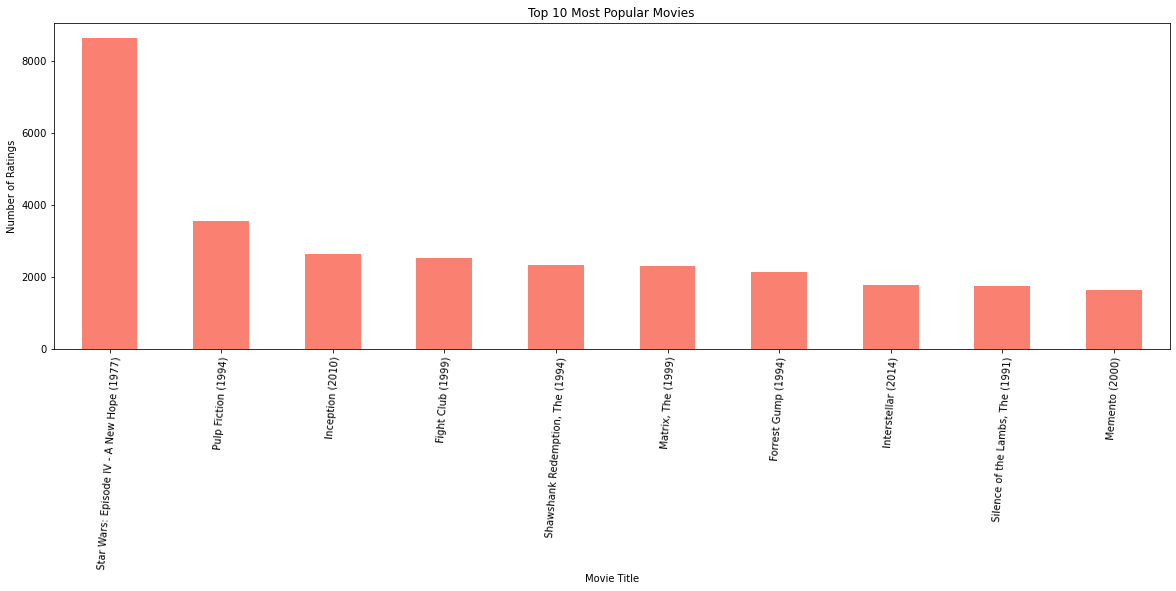

In [173]:
#most ratings falling between 3.6 and 4.6.
# Most Popular Movies (Top 10)
top_movies = combined_df['title'].value_counts().nlargest(10)
plt.figure(figsize=(20, 6))
top_movies.plot(kind='bar',color='salmon')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.title('Top 10 Most Popular Movies')
plt.xticks(rotation=86)
plt.show()

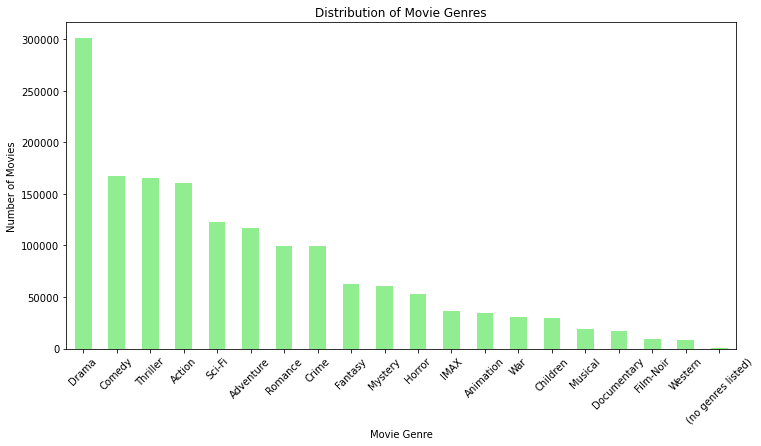

In [174]:
# Split the genres into a list and explode them into separate rows
combined_df['genres'] = combined_df['genres'].str.split('|')
exploded_genres = combined_df.explode('genres')

# Get the value counts for each genre (excluding NaN values)
genres_counts = exploded_genres['genres'].value_counts()

plt.figure(figsize=(12, 6))
genres_counts.plot(kind='bar',color='lightgreen')
plt.xlabel('Movie Genre')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Genres')
plt.xticks(rotation=45)
plt.show()

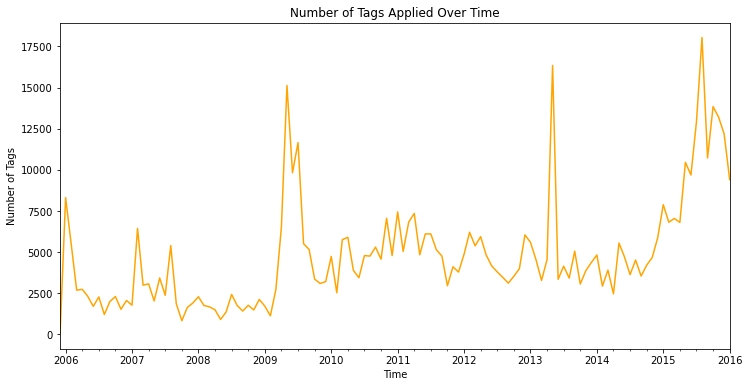

In [177]:
#The majority of users have rated a relatively small number of movies (between 0 and 200).

# Time-Based Analysis for Tags
# Sort the data by 'tag_timestamp'
combined_df.sort_values(by='tag_timestamp', inplace=True)

# Time-Based Analysis for Tags
tag_count_by_time = combined_df.groupby(pd.Grouper(key='tag_timestamp', freq='M')).size()

# Plot the number of tags applied over time
plt.figure(figsize=(12, 6))
tag_count_by_time.plot(color='orange') 
plt.xlabel('Time')
plt.ylabel('Number of Tags')
plt.title('Number of Tags Applied Over Time')
plt.show()

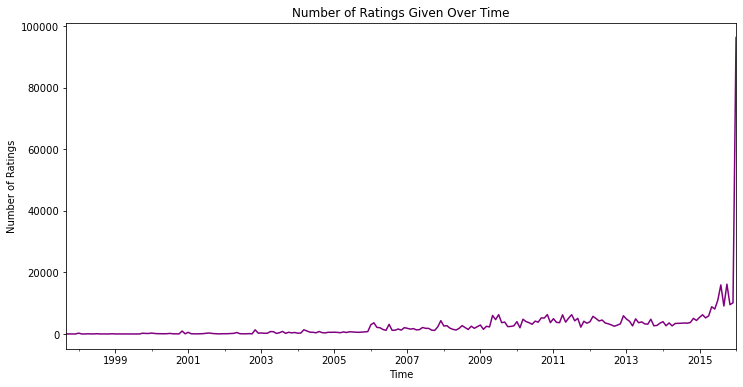

In [178]:
#Time-Based Analysis for Ratings

# Sort the data by 'rating_timestamp'
combined_df.sort_values(by='rating_timestamp', inplace=True)

# Time-Based Analysis for Ratings
rating_count_by_time = combined_df.groupby(pd.Grouper(key='rating_timestamp', freq='M')).size()

# Plot the number of ratings given over time
plt.figure(figsize=(12, 6))
rating_count_by_time.plot(color='purple')
plt.xlabel('Time')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings Given Over Time')
plt.show()

# Movies rating based 

In [29]:
# Group by movieId and get the maximum rating for each movie
highest_ratings = combined_df.groupby('movieId')['rating'].max().reset_index()

# Merge with the original dataframe to get the corresponding movie titles
highest_ratings = highest_ratings.merge(combined_df[['movieId', 'title']], on='movieId')

# Rename columns for clarity
highest_ratings.rename(columns={'rating': 'highest_rating'}, inplace=True)

# Display the result
highest_ratings.drop_duplicates(inplace=True)

highest_ratings

,movieId,highest_rating,title
0,1,5.0,Toy Story (1995)
548,2,5.0,Jumanji (1995)
687,3,4.5,Grumpier Old Men (1995)
705,4,4.0,Waiting to Exhale (1995)
712,5,4.5,Father of the Bride Part II (1995)
...,...,...,...
586971,151567,3.0,The War in Space (1977)
586976,151599,4.5,Capital C (2015)
586979,151621,4.0,Looking for Grace (2015)
586985,151677,3.0,Last Hippie Standing (2002)


In [116]:
from sklearn.model_selection import train_test_split
from ast import literal_eval
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
# from surprise import Reader, Dataset, SVD, evaluate
import warnings
warnings.filterwarnings('ignore')

In [117]:
df = pd.read_csv('movies_metadata.csv')
df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [118]:
df['genres'] = df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
#Weighted Rating (WR) =  (vv+m.R)+(mv+m.C)
#v is the number of votes for the movie
#m is the minimum votes required to be listed in the chart
#R is the average rating of the movie
#C is the mean vote across the whole report

In [119]:
vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [120]:
m = vote_counts.quantile(0.95)
m

434.0

In [121]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [122]:
qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [123]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)   
# movieownvotecount+globalvotecount

In [124]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [126]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [127]:
#top movies(above 95%)--
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


In [128]:
# above 85 percentile - based on genre
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_df = df.drop('genres', axis=1).join(s)

In [129]:
def build_chart(genre, percentile=0.85):
    df = gen_df[gen_df['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [130]:
qualified.head(20)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


In [131]:
# will tell top romance movies --
build_chart('Romance')

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.20822,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154
...,...,...,...,...,...,...
7582,How to Steal a Million,1966,133,7,12.389626,6.352112
6912,Beauty and the Beast,1946,133,7,4.798852,6.352112
24888,Remember Sunday,2013,131,7,11.190606,6.346273
2801,Body Heat,1981,128,7,5.991482,6.337313


In [132]:
build_chart('Action')

,title,year,vote_count,vote_average,popularity,wr
15480,Inception,2010,14075,8,29.108149,7.955099
12481,The Dark Knight,2008,12269,8,123.167259,7.948610
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,7.929579
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,7.924031
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,7.918382
...,...,...,...,...,...,...
21296,The Wolverine,2013,4110,6,3.918287,5.956636
13635,X-Men Origins: Wolverine,2009,4086,6,1.456541,5.956395
5244,Star Wars: Episode II - Attack of the Clones,2002,4074,6,14.072511,5.956273
18289,Mission: Impossible - Ghost Protocol,2011,4026,6,14.25843,5.955779


In [138]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [139]:
# Fill NaN values in 'title' and 'tag'
df['title'] = df['title'].fillna('')
df['tag'] = df['tag'].fillna('')

# Combine 'title' and 'tag' into a new column 'combined'
df['combined'] = df['title'] + ' ' + df['tag']

# Verify there are no NaNs in the combined column
print(df['combined'].isnull().sum())  # Should print 0

# Display the first few rows of the dataset with the combined column
print(df[['title', 'tag', 'combined']].head())

0
                         title  \
0                    Toy Story   
1                      Jumanji   
2             Grumpier Old Men   
3            Waiting to Exhale   
4  Father of the Bride Part II   

                                                 tag  \
0                                                      
1          Roll the dice and unleash the excitement!   
2  Still Yelling. Still Fighting. Still Ready for...   
3  Friends are the people who let you be yourself...   
4  Just When His World Is Back To Normal... He's ...   

                                            combined  
0                                         Toy Story   
1  Jumanji Roll the dice and unleash the excitement!  
2  Grumpier Old Men Still Yelling. Still Fighting...  
3  Waiting to Exhale Friends are the people who l...  
4  Father of the Bride Part II Just When His Worl...  


In [140]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the 'combined' data
tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined'])

# Check the shape of the TF-IDF matrix
print(tfidf_matrix.shape)

(45466, 27947)


In [141]:
# Reduce dimensionality
svd = TruncatedSVD(n_components=100)  # Adjust n_components based on your memory constraints
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

# Check the shape of the reduced TF-IDF matrix
print(tfidf_matrix_reduced.shape)

(45466, 100)


In [142]:
# Compute cosine similarity matrix on the reduced TF-IDF matrix
cosine_sim = cosine_similarity(tfidf_matrix_reduced, tfidf_matrix_reduced)

# Display the shape of the cosine similarity matrix
print(cosine_sim.shape)

MemoryError: Unable to allocate 15.4 GiB for an array with shape (45466, 45466) and data type float64